In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

> This notebook aims to push the public LB under 0.50. Certainly, the competition is not yet at its peak and there clearly remains room for improvement.

# Credits

* [First R notebook](https://www.kaggle.com/kailex/m5-forecaster-v2)
* [Python translation](https://www.kaggle.com/kneroma/m5-forecast-v2-python)

# Changes
* v5 : try to optimise the LGBM params (go below in lgbm params section to see changes)
* v4 : add df, X_train deletion before training step --> increasing train sample without memeroy issues

In [2]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [3]:
pd.options.display.max_columns = 50

In [4]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [9]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("./sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("./calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("./sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [10]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [11]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [12]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 15.7 s, sys: 2.22 s, total: 17.9 s
Wall time: 17.9 s


(46027957, 22)

In [13]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory us

In [15]:
%%time

create_fea(df)
df.shape

CPU times: user 1min 36s, sys: 4.85 s, total: 1min 41s
Wall time: 1min 41s


(46027957, 31)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [17]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [18]:
df.dropna(inplace = True)
df.shape

(44351007, 31)

In [19]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [ ]:
# train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
# fake_valid_inds = np.random.choice(len(X_train), 1000000, replace = False)
# fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
#                              free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [20]:
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

CPU times: user 8.43 s, sys: 444 ms, total: 8.88 s
Wall time: 8.87 s


In [21]:
del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

175

In [22]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [23]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 3.07872
[40]	valid_0's rmse: 2.60668
[60]	valid_0's rmse: 2.48198
[80]	valid_0's rmse: 2.44539
[100]	valid_0's rmse: 2.43286
[120]	valid_0's rmse: 2.42396
[140]	valid_0's rmse: 2.4169
[160]	valid_0's rmse: 2.40911
[180]	valid_0's rmse: 2.40122
[200]	valid_0's rmse: 2.39673
[220]	valid_0's rmse: 2.39224
[240]	valid_0's rmse: 2.3871
[260]	valid_0's rmse: 2.38334
[280]	valid_0's rmse: 2.37875
[300]	valid_0's rmse: 2.37357
[320]	valid_0's rmse: 2.36974
[340]	valid_0's rmse: 2.36675
[360]	valid_0's rmse: 2.36283
[380]	valid_0's rmse: 2.35938
[400]	valid_0's rmse: 2.35622
[420]	valid_0's rmse: 2.35369
[440]	valid_0's rmse: 2.3503
[460]	valid_0's rmse: 2.3479
[480]	valid_0's rmse: 2.34581
[500]	valid_0's rmse: 2.34353
[520]	valid_0's rmse: 2.34067
[540]	valid_0's rmse: 2.33908
[560]	valid_0's rmse: 2.33706
[580]	valid_0's rmse: 2.33419
[600]	valid_0's rmse: 2.33263
[620]	valid_0's rmse: 2.33068
[640]	valid_0's rmse: 2.32895
[660]	valid_0's rmse: 2.32711
[680]	valid_0's rm

In [24]:
m_lgb.save_model("model.lgb")

In [29]:
m_lgb

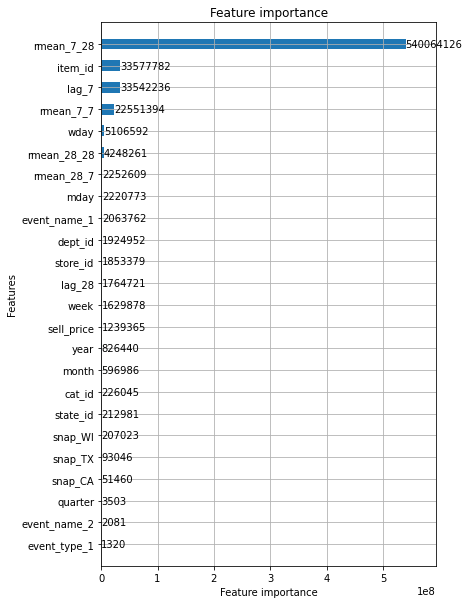

In [30]:
lgb.plot_importance(m_lgb, importance_type="gain", precision=0, height=0.5, figsize=(6, 10))

In [25]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    #te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2

In [26]:
sub.head(10)

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.921982,0.844058,0.831086,0.804317,1.085813,1.243053,1.220499,0.988189,0.954387,0.955022,0.962885,1.101673,1.324597,1.115200,0.978897,0.930624,0.935303,0.931647,1.053906,1.327939,1.211202,0.945561,0.847635,0.825210,0.837196,1.019056,1.246700,1.224303
1,FOODS_1_001_CA_2_validation,0.933447,1.013225,0.926307,1.226641,1.291296,1.665550,1.461644,0.926162,0.959716,0.931226,0.981850,1.132415,1.595127,1.255730,1.057911,1.013983,1.027201,1.030942,1.252602,1.804426,1.541713,1.067880,1.022080,1.036543,1.056901,1.306102,1.835952,1.462495
2,FOODS_1_001_CA_3_validation,1.094505,1.058371,0.997684,0.965104,1.031709,1.159111,1.411858,1.093429,1.096491,1.007252,1.051162,1.097961,1.380209,1.269333,1.163170,1.148452,1.063134,1.071958,1.131133,1.469768,1.603783,1.169297,1.103502,1.013981,1.004343,1.093843,1.298277,1.257718
3,FOODS_1_001_CA_4_validation,0.391942,0.354295,0.353947,0.360267,0.432364,0.480818,0.511920,0.421208,0.429300,0.421559,0.408678,0.422016,0.454026,0.416228,0.381254,0.383513,0.406885,0.427830,0.447266,0.496185,0.515312,0.380202,0.369758,0.377320,0.380057,0.432982,0.492540,0.495353
4,FOODS_1_001_TX_1_validation,0.174362,0.172217,0.161773,0.163743,0.158014,0.180625,0.212484,0.526287,0.455958,0.452961,0.486556,0.525156,0.500347,0.436662,0.405928,0.558370,0.370444,0.356407,0.417704,0.389290,0.378465,0.306771,0.285059,0.282675,0.283965,0.330963,0.363307,0.356366
5,FOODS_1_001_TX_2_validation,0.443577,0.415351,0.420254,0.395534,0.432940,0.515729,0.548240,0.441304,0.464658,0.445028,0.518930,0.526456,0.612909,0.574181,0.479259,0.457697,0.487077,0.465913,0.525774,0.564946,0.583245,0.441318,0.432620,0.441470,0.439677,0.488539,0.553047,0.531582
6,FOODS_1_001_TX_3_validation,0.389895,0.350424,0.355416,0.410132,0.450150,0.476659,0.571535,0.472164,0.524234,0.483456,0.494030,0.521779,0.565306,0.516157,0.459668,0.442001,0.469887,0.487988,0.514967,0.550956,0.565649,0.455115,0.432153,0.446306,0.441665,0.479695,0.538411,0.510341
7,FOODS_1_001_WI_1_validation,0.335757,0.386035,0.370015,0.369474,0.463967,0.890019,0.598039,0.486945,0.444261,0.417692,0.516105,0.612000,0.803343,0.626112,0.534253,0.535642,0.565356,0.570377,0.690528,0.894678,0.777701,0.558193,0.545927,0.569495,0.592224,0.730461,0.973454,0.814158
8,FOODS_1_001_WI_2_validation,0.311138,0.347861,0.365954,0.350935,0.424670,0.443626,0.443043,0.433560,0.500992,0.429230,0.474478,0.533477,0.545027,0.449099,0.446837,0.425533,0.480317,0.478054,0.480162,0.575319,0.529203,0.391332,0.393356,0.382368,0.390424,0.424294,0.478928,0.438591
9,FOODS_1_001_WI_3_validation,0.228807,0.224957,0.212293,0.216251,0.269305,0.400799,0.376283,0.354767,0.382252,0.348444,0.381124,0.429993,0.448760,0.395019,0.337448,0.338358,0.353925,0.353943,0.406407,0.452290,0.437066,0.320944,0.305759,0.323189,0.323311,0.385020,0.429254,0.366659


In [27]:
sub.id.nunique(), sub["id"].str.contains("validation$").sum()

(60980, 30490)

In [28]:
sub.shape

(60980, 29)